# Hệ thống dự đoán khách hàng rời bỏ ngân hàng
Hệ thống Dự đoán Ngân hàng là một dự án nhằm dự đoán khách hàng sẽ rời bỏ ngân hàng hay không, dựa trên dữ liệu lịch sử về hành vi của khách hàng. Các đặc điểm chính của tập dữ liệu bao gồm thông tin nhân khẩu học của khách hàng, thông tin tài chính và các yếu tố liên quan đến hành vi (chẳng hạn như số dư, điểm tín dụng, thời gian gắn bó, v.v.). Biến mục tiêu là "Exited", cho biết liệu khách hàng đã rời ngân hàng hay chưa (1 = Có, 0 = Không).


# Load Data


In [11]:

import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('Churn_Modelling.csv')

# Kiểm tra kiểu dữ liệu và mất mát dữ liệu
print(df.info())

df = df.dropna()

# Biến 2 trường 'Geography', 'Gender' thành biến giả
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
   RowNumber  CustomerId   Surname  CreditScore  Age  Tenure    Balance  \
0          1  

# Tiền xử lí dữ liệu
- Tạo thêm một đặc trưng mới để cải thiện độ chính xác
- Xác định các cột không phải số hoặc các giá trị có vấn đề
- Thay thế hoặc loại bỏ các giá trị có vấn đề

In [12]:
# Tạo thêm đặc trưng BalanceSalaryRatio
df['BalanceSalaryRatio'] = df['Balance'] / df['EstimatedSalary']
print(df['BalanceSalaryRatio'].head())

0    0.000000
1    0.744677
2    1.401375
3    0.000000
4    1.587055
Name: BalanceSalaryRatio, dtype: float64


In [13]:
# Xác định các cột không phải số hoặc các giá trị có vấn đề
for column in df.columns:
    if df[column].dtype == object:
        print(f"Non-numeric values found in column: {column}")
        print(df[column].unique())  # Print unique values to inspect
# Thay thế hoặc loại bỏ các giá trị có vấn đề
df = df.replace("P'an", np.nan)  # Thay thế các giá trị P'an thành NaN

# Loại bỏ các hàng chứa giá trị NaN
df = df.dropna()


Non-numeric values found in column: Surname
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']


# Huấn luyện mô hình
Hồi quy tuyến tính

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score

# Loại bỏ cột không cần thiết
df = df.drop(columns=['RowNumber','CustomerId','Surname'])

# Chia tập dữ liệu
X = df.drop('Exited', axis=1)  # 'Exited' là giá trị cần dự đoán
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện với mô hình hồi quy tuyến tính
lr = LinearRegression()
lr.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = lr.predict(X_test)


# Chuyển đổi các giá trị liên tục thành các giá trị nhị phân cho phân loại
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Đánh giá mô hình
accuracy_lr = accuracy_score(y_test, y_pred_binary)
precision_lr = precision_score(y_test, y_pred_binary)

print(f'Accuracy: {accuracy_lr}')
print(f'Precision: {precision_lr}')


Accuracy: 0.8214107053526764
Precision: 0.6818181818181818


In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import mean_squared_error

# Huấn luyện với mô hình Ridge
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_pred_ridge_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_ridge]

# Đánh giá mô hình
mse_ridge = mean_squared_error(y_test, y_pred_ridge_binary)
print(f'Ridge MSE: {mse_ridge}')

Ridge MSE: 0.17858929464732365


In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

neural_nw = MLPRegressor(hidden_layer_sizes=100,activation='relu',solver='sgd',max_iter=1000,random_state=42,alpha=0.0001,learning_rate="constant")

neural_nw.fit(X_train,y_train)
y_pred_neural_nw = neural_nw.predict(X_test)
y_pred_neural_nw_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_neural_nw]

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.1331369554662284
R-squared: 0.15052865736319565


# Ma trận lỗi

Ma trận lỗi Linear Regression:
[[1582   28]
 [ 329   60]]


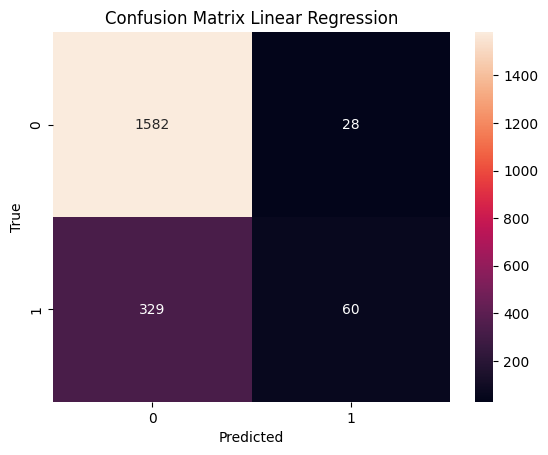


Ma trận lỗi Matrix Ridge:
[[1582   28]
 [ 329   60]]


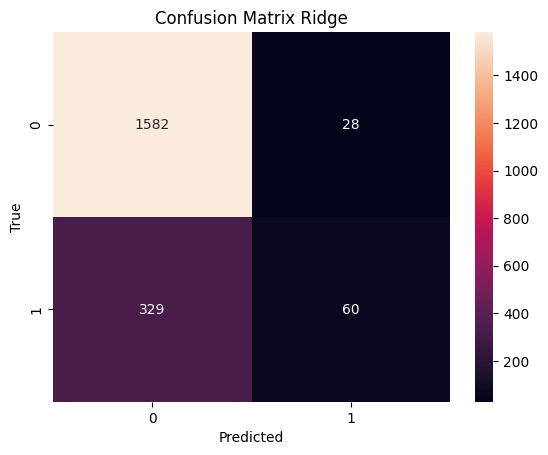


Ma trận lỗi Neural network:
[[   0 1610]
 [   0  389]]


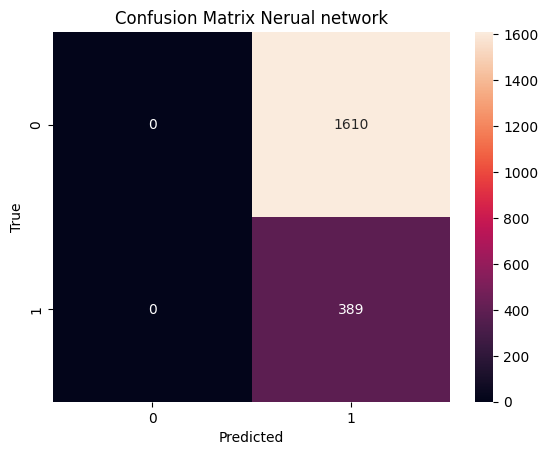

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix_lr = confusion_matrix(y_test, y_pred_binary)
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge_binary)
conf_matrix_nnw = confusion_matrix(y_test, y_pred_neural_nw_binary)

print("Ma trận lỗi Linear Regression:")
print(conf_matrix_lr)
# Vẽ ma trận nhầm lẫn bằng seaborn
sns.heatmap(conf_matrix_lr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Linear Regression')
plt.show()

print("\nMa trận lỗi Matrix Ridge:")
print(conf_matrix_ridge)
sns.heatmap(conf_matrix_ridge, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Ridge')
plt.show()

print("\nMa trận lỗi Neural network:")
print(conf_matrix_nnw)
sns.heatmap(conf_matrix_nnw, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Nerual network')
plt.show()

# Tối ưu hoá mô hình

In [18]:
from sklearn.model_selection import GridSearchCV
ridge_params = {'alpha': [0.0001,0.001,0.01, 0.1, 1.0, 10.0, 100.0]}

ridge = Ridge()

ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)

# Giá trị tối ưu nhất
print(f"Best Ridge alpha: {ridge_grid.best_params_}")

Best Ridge alpha: {'alpha': 0.0001}


In [19]:

from sklearn.feature_selection import SelectKBest, f_regression

# Tìm ra các đặc trưng tốt nhất
selector = SelectKBest(f_regression, k=10)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

# Re-train
lr.fit(X_train_new, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lr_new = lr.predict(X_test_new)


# Chuyển đổi các giá trị liên tục thành các giá trị nhị phân cho phân loại
y_pred_binary_new = [1 if pred >= 0.5 else 0 for pred in y_pred_lr_new]

# Đánh giá mô hình
accuracy_lr_new = accuracy_score(y_test, y_pred_binary_new)
precision_lr_new = precision_score(y_test, y_pred_binary_new)

print(f'Accuracy: {accuracy_lr_new}')
print(f'Precision: {precision_lr_new}')


Accuracy: 0.822911455727864
Precision: 0.7011494252873564


In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint

# Tạo dữ liệu mẫu
# ...

# Khởi tạo mô hình
model = MLPClassifier()

# Định nghĩa không gian tham số
param_dist = {
    'hidden_layer_sizes': [(int(x)) for x in np.linspace(start = 0, stop = 500, num = 10)],
    'activation': ['relu', 'tanh'],
    'alpha': uniform(loc=0.0001, scale=0.05),
    'learning_rate': ['constant','adaptive'],
}

# Tìm kiếm các tham số tốt nhất
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5)
random_search.fit(X_train, y_train)

# In kết quả
print(random_search.best_params_)
print(random_search.best_score_)

{'activation': 'tanh', 'alpha': np.float64(0.03526441394796338), 'hidden_layer_sizes': 55, 'learning_rate': 'constant'}
0.7938196667034543


In [21]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

neural_nw_new = MLPRegressor(hidden_layer_sizes=(10,500),activation='tanh',solver='sgd',max_iter=1000,random_state=42,alpha=0.0003512748675747079,learning_rate="adaptive")

neural_nw_new.fit(X_train,y_train)
y_pred_neural_nw_new = neural_nw_new.predict(X_test)
y_pred_neural_nw_binary_new = [1 if pred >= 0.5 else 0 for pred in y_pred_neural_nw_new]

# Đánh giá mô hình

train_score = neural_nw_new.score(X_train, y_train)
print("Độ chính xác trên tập huấn luyện:", train_score)
test_score = neural_nw_new.score(X_test, y_test)
print("Độ chính xác trên tập kiểm tra:", test_score)

Độ chính xác trên tập huấn luyện: 0.014974228011459423
Độ chính xác trên tập kiểm tra: 0.011055878980691825
